


# Object Detection

This notebook implements an object detector based on gradient features and sliding window classification. 

---
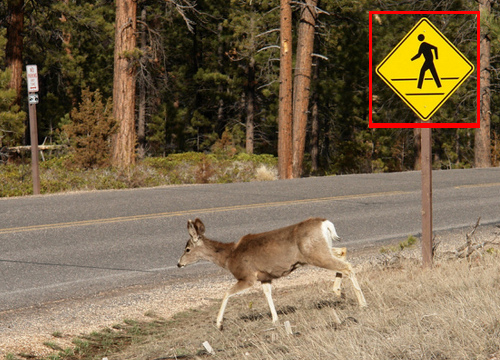

In [4]:
import numpy as np
import matplotlib.pyplot as plt

---
# Image Gradients Function

This function takes a grayscale image as input and returns two arrays the same size as the image, the first of which contains the magnitude of the image gradient at each pixel and the second containing the orientation.

The function filters the image with simple x- and y-derivative filters. It then computes the orientation and magnitude of the gradient vector at each pixel.

Included is a visualization of the output of the gradient calculation for a small test image. 

In [76]:
from scipy import ndimage

def mygradient(image):
    """
    This function takes a grayscale image and returns two arrays of the
    same size, one containing the magnitude of the gradient, the second
    containing the orientation of the gradient.
    
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    Returns
    -------
    mag : 2D float array of shape HxW
        gradient magnitudes
        
    ori : 2Dfloat array of shape HxW
        gradient orientations in radians
    """
    
    dx = np.zeros(image.shape)
    dy = np.zeros(image.shape)
    
    weight_dx = np.array([[0, 0, 0],
                           [0, 0, 1],
                           [0, 0, 0]])
    
    weight_dy = np.array([[0, 0, 0],
                           [0, 0, 0],
                           [0, 1, 0]])
    
    cor_dx = ndimage.correlate(image, weight_dx, dx, mode='nearest')
    cor_dy = ndimage.correlate(image, weight_dy, dy, mode='nearest')
    
    dx = dx - image
    dy = dy - image
    
    ori = np.zeros(image.shape)
    
    dydx = np.zeros(image.shape)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            ans = 0
            if dx[y,x] == 0 and dy[y,x] == 0:
                ans = 0
            elif dx[y,x] == 0:
                ans = dy[y,x]
            else:
                ans = dy[y,x] / dx[y,x]
            dydx[y,x] = ans
    
    ori = np.arctan(dydx)
    
    mag = np.zeros(image.shape)
    mag = np.sqrt( dx * dx + dy * dy )
    
    return (mag,ori)

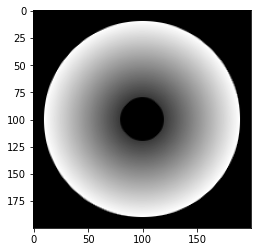

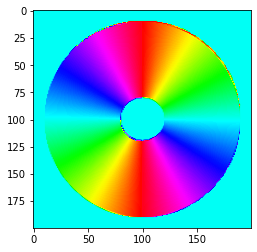

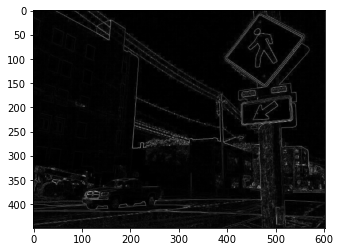

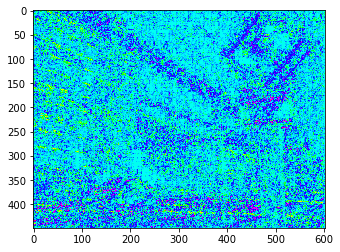

In [77]:
#
# test and debugging block
#


# this generated test image has gradients pointed in all directions 
[yy,xx] = np.mgrid[-100:100,-100:100]
testimage = np.minimum(np.maximum(np.array(xx*xx+yy*yy,dtype=float),400),8100)

image = testimage

(mag,ori) = mygradient(image)

#visualize results mag,ori as images

fig = plt.figure()

plt.imshow(mag,cmap=plt.cm.gray)
plt.show()

plt.imshow(ori,cmap=plt.cm.hsv)
plt.show()

#### imported images

myimage = plt.imread('images/signs/test1.jpg')
if (myimage.dtype == np.uint8):
    myimage = myimage.astype(float) / 256
myimage = np.average(myimage, -1)
(mag,ori) = mygradient(myimage)

plt.imshow(mag,cmap=plt.cm.gray)
plt.show()

plt.imshow(ori,cmap=plt.cm.hsv)
plt.show()

####


---

# Histograms of Gradient Orientations

This function computes gradient orientation histograms over each 8x8 block of pixels in an image. The function bins the orientation into 9 equal sized bins between -pi/2 and pi/2. The input of the function will be an image of size HxW. The output be a three-dimensional array ***ohist*** whose size is (H/8)x(W/8)x9 where ***ohist[i,j,k]*** contains the count of how many edges of orientation k fell in block (i,j). If the input image dimensions are not a multiple of 8, ***np.pad*** is used with the ***mode=edge*** option to pad the width and height up to the nearest integer multiple of 8.

To determine if a pixel is an edge, the function use a threshold of 10% of the maximum gradient magnitude in the image. Since each 8x8 block will contain a different number of edges, it will normalize the resulting histogram for each block to sum to 1 (i.e., ***np.sum(ohist,axis=2)*** should be 1 at every  location).

The function loops over the orientation bins. For each orientation bin it will identify those pixels in the image whose gradient magnitude is above the threshold and whose orientation falls in the given bin. To collect up pixels in each 8x8 spatial block, it uses the function ***ski.util.view_as_windows(...,(8,8),step=8)*** and ***np.count_nonzeros*** to count the number of edges in each block.

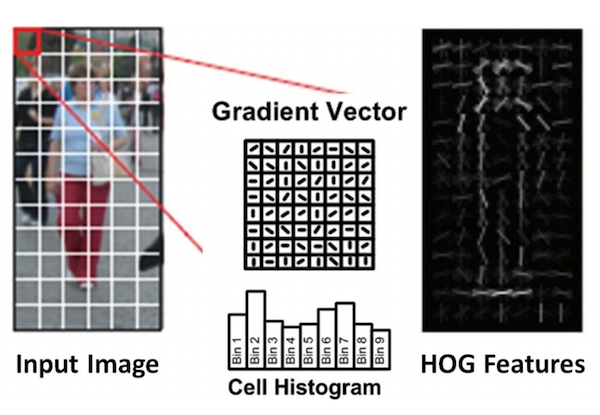

In [94]:

import skimage as ski 

def hog(image,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and returns a 3D array
    containing the histogram of gradient orientations descriptor (HOG)
    We follow the convention that the histogram covers gradients starting
    with the first bin at -pi/2 and the last bin ending at pi/2.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
        
    Returns
    -------
    ohist : 3D float array of shape (H/bsize,W/bsize,norient)
        edge orientation histogram
        
    """   
    
    # determine the size of the HOG descriptor
    (h,w) = image.shape
    h2 = int(np.ceil(h/float(bsize)))
    w2 = int(np.ceil(w/float(bsize)))
    ohist = np.zeros((h2,w2,norient))
    
    # pad the input image on right and bottom as needed so that it 
    # is a multiple of bsize
    
    nearest_mult_w = bsize * np.ceil( w / float(bsize) )
    nearest_mult_h = bsize * np.ceil( h / float(bsize) )
    
    pad_w = int(nearest_mult_w - w)
    pad_h = int(nearest_mult_h - h)
    
    pw = (0,pad_w) #amounts to pad on left and right side
    ph = (0,pad_h) #amounts to pad on bottom and top side
    image = np.pad(image,(ph,pw),'edge')
    
    # make sure we did the padding correctly
    assert(image.shape==(h2*bsize,w2*bsize))
    
    # compute image gradients
    (mag,ori) = mygradient(image)
    
    # choose a threshold which is 10% of the maximum gradient magnitude in the image
    thresh = float(np.amax(mag)) * 0.1
    
    
    # separate out pixels into orientation channels, dividing the range of orientations
    # [-pi/2,pi/2] into norient equal sized bins and count how many fall in each block    
    binEdges = np.linspace(-np.pi/2, np.pi/2, norient+1);
    
    # as a sanity check, make sure every pixel gets assigned to at most 1 bin.
    bincount = np.zeros((h2*bsize,w2*bsize))   
    for i in range(norient):
        #create a binary image containing 1s for pixels at the ith 
        #orientation where the magnitude is above the threshold.
        B = np.zeros(mag.shape)
        B[(mag > thresh) & ((ori>=binEdges[i]) & (ori<binEdges[i+1]))] = 1
        B[(mag <= thresh) | ((ori<binEdges[i]) | (ori>=binEdges[i+1]))] = 0
    
        #sanity check: record which pixels have been selected at this orientation
        bincount = bincount + B
        
        #pull out non-overlapping bsize x bsize blocks
        chblock = ski.util.view_as_windows(B,(bsize,bsize),step=bsize)
    
        #sum up the count for each block and store the results
        ohist[:,:,i] = np.sum(chblock, axis=(2,3))
       
    #each pixel should have only selected at most once
    assert(np.all(bincount<=1))

    # lastly, normalize the histogram so that the sum along the orientation dimension is 1
    # note: don't divide by 0! If there are no edges in a block (i.e. the sum of counts
    # is 0) then your code should leave all the values as zero. 
    
    block_sum = ohist.sum(axis=2)
    block_sum[block_sum == 0] = 1
    ohist = ohist / block_sum[:,:,np.newaxis]
    
    assert(ohist.shape==(h2,w2,norient))
#     print(ohist)
    
    return ohist

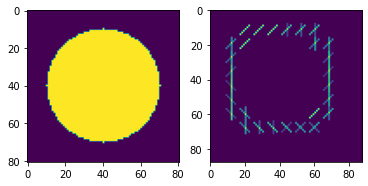

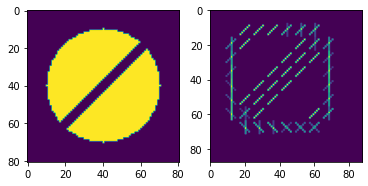

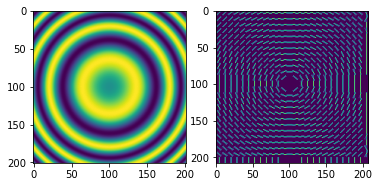

In [96]:
#function for visualizing hog descriptors
from hogvis import hogvis

#
# generate a simple test image... a 80x80 image
# with a circle of radius 30 in the center
#
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)

#
# display the image and the output of hogvis
#
hogim = hogvis(hog(im))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()

# two other synthetic test images to experiment with
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)
im[np.abs(xx+yy)<=3] = 0

hogim = hogvis(hog(im))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()



[yy,xx] = np.mgrid[-100:101,-100:101]
im = np.array(np.sin((xx*xx+yy*yy)/800),dtype=float)

hogim = hogvis(hog(im))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()



---
# Detection

This function takes a template and an image and returns the top detections found in the image. 

The function first computes the histogram-of-gradient-orientation feature map for the image, then correlate the template with the feature map. Since the feature map and template are both three dimensional, it filters each orientation separately and then sum up the results to get the final response. If the image of size HxW then this final response map will be of size (H/8)x(W/8).

When constructing the list of top detections, the functions uses non-maxima suppression so that it doesn't return overlapping detections. It achieves this by sorting the responses in descending order of their score. Every time a detection is added to the list to return, the function checks to make sure that the location of this detection is not too close to any of the detections already in the output list. The overlap is estimated by computing the distance between a pair of detections and checking that the distance is greater than 70% of the width of the template.

In [213]:
from scipy import ndimage

def detect(image,template,ndetect=5,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and a HOG template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : a 3D float array 
        The HOG template we wish to match to the image
        
    ndetect : int
        Maximum number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
        
    """   
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==norient)
    
    fmap = hog(image,bsize=bsize,norient=norient)
    
    
    #cross-correlate the template with the feature map to get the total response
    resp = np.zeros((fmap.shape[0],fmap.shape[1]))
    for i in range(norient):
        resp = resp + ndimage.correlate(fmap[:,:,i], template[:,:,i])
    
    #sort the values in resp in descending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]]
    # 
    ind = np.flip(np.argsort(resp, axis=None))  #corresponding indices
    twod_ind = np.unravel_index(ind, resp.shape)
    twod_ind = np.array((twod_ind[0],twod_ind[1])).T
    
    val = resp[twod_ind[:,0],twod_ind[:,1]]    
    
    #work down the list of responses from high to low, to generate a 
    # list of ndetect top scoring matches which do not overlap
    detcount = 0
    i = 0
    detections = []
    while ((detcount < ndetect) and (i < len(val))):
        # convert 1d index into 2d index
        yb = twod_ind[i][0]
        xb = twod_ind[i][1]
    
        assert(val[i]==resp[yb,xb]) #make sure we did indexing correctly
        
        #covert block index to pixel coordinates based on bsize
        xp = bsize * xb
        yp = bsize * yb
    
        #check if this detection overlaps any detections that we've already added
        #to the list. compare the x,y coordinates of this detection to the x,y 
        #coordinates of the detections already in the list and see if any overlap
        #by checking if the distance between them is less than 70% of the template
        # width/height
    
        overlap = False
        seventy_percent = float(template.shape[1] * bsize) * 0.7
        for item in detections:
            
            oldx = item[0]
            oldy = item[1]
            
            xdif = oldx - xp
            ydif = oldy - yp
            
            dist = np.sqrt((xdif * xdif) + (ydif * ydif))
            if dist < seventy_percent:
                overlap = True
                break
        
        #if the detection doesn't overlap then add it to the list
        if not overlap:
            detcount = detcount + 1
            detections.append((xp,yp,val[i]))
        
        i=i+1
    
    if (len(detections) < ndetect):
        print('WARNING: unable to find ',ndetect,' non-overlapping detections')
        
    return detections

In [214]:
import matplotlib.patches as patches

def plot_detections(image,detections,tsize_pix):
    """
    This is a utility function for visualization that takes an image and
    a list of detections and plots the detections overlayed on the image
    as boxes.
    
    Color of the bounding box is based on the order of the detection in
    the list, fading from green to red.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    detections : a list of tuples of length ndetect
        Detections are tuples (x,y,score)

    tsize_pix : (int,int)
        The height and width of the box in pixels
    
    Returns
    -------
    None
    
    """           
    ndetections = len(detections)
    
    plt.imshow(image,cmap=plt.cm.gray)
    ax = plt.gca()
    w = tsize_pix[1]
    h = tsize_pix[0]
    red = np.array([1,0,0])
    green = np.array([0,1,0])
    ct = 0
    for (x,y,score) in detections:
        xc = x-(w//2)
        yc = y-(h//2)
        col = (ct/ndetections)*red + (1-(ct/ndetections))*green
        rect = patches.Rectangle((xc,yc),w,h,linewidth=3,edgecolor=col,facecolor='none')
        ax.add_patch(rect)
        ct = ct + 1
        
    plt.show()

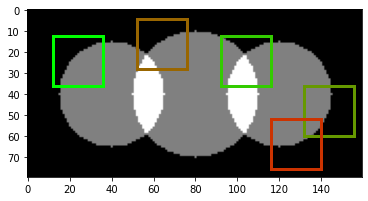

In [219]:
#
# sketch of some simple test code,
#

#create a synthetic image with some overlapping circles
[yy,xx] = np.mgrid[-40:40,-80:80]
im1 = np.array((xx*xx+yy*yy<=30*30),dtype=float)
[yy,xx] = np.mgrid[-40:40,-40:120]
im2 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
[yy,xx] = np.mgrid[-40:40,-120:40]
im3 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
im = (1/3)*(im1+im2+im3)


#compute feature map with default parameters
fmap = hog(im)

#extract a 3x3 template
template = fmap[2:5,2:5,:]

#run the detect code
detections = detect(im,template,ndetect=5)

#visualize results. 
plot_detections(im,detections,(3*8,3*8))


---
# Learning Templates 

This function learns a template from positive and negative examples. It takes a collection of cropped positive and negative examples of the object we are interested in detecting, extract the features for each, and generate a template by taking the average positive template minus the average negative template.



In [252]:
from skimage.transform import resize

def learn_template(posfiles,negfiles,tsize=np.array([16,16]),bsize=8,norient=9):
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a HOG template and generates visualization
    of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks
    
    Returns
    -------
    template : float array of size tsize x norient
        The learned HOG template
    
    """           
    
    #compute the template size in pixels 
    #corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    #figure to show positive training examples
    fig1 = plt.figure()
    pltct = 1

    #accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in posfiles:
        #load in a cropped positive example
        img = plt.imread('images/' + file)
        if (img.dtype == np.uint8):
            img = img.astype(float) / 256
        img = np.average(img, -1)
        img_scaled = resize(img, tsize_pix)

        #convert to grayscale and resize to fixed dimension tsize_pix
        #using skimage.transform.resize if needed.

        #display the example. if you want to train with a large # of examples, 
        #you may want to modify this, e.g. to show only the first 5.
        ax = fig1.add_subplot(1,len(posfiles),pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature
        fmap = hog(img_scaled)

        #compute running average
        pos_t = pos_t + fmap

    pos_t = (1/len(posfiles))*pos_t
    plt.tight_layout()
    plt.show()
    
    # repeat same process for negative examples
    fig2 = plt.figure()
    pltct = 1  
    neg_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in negfiles:
        #load in a cropped positive example
        img = plt.imread('images/' + file)
        if (img.dtype == np.uint8):
            img = img.astype(float) / 256
        img = np.average(img, -1)
        img_scaled = resize(img, tsize_pix)
        
        ax = fig2.add_subplot(1,len(negfiles),pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature
        fmap = hog(img_scaled)

        #compute running average
        neg_t = neg_t + fmap
        

    neg_t = (1/len(negfiles))*neg_t
    plt.tight_layout()
    plt.show()

    # add code here to visualize the positive and negative parts of the template
    # using hogvis. you should separately visualize pos_t and neg_t rather than
    # the final tempalte.
    fig3 = plt.figure()
    plt.imshow(hogvis(pos_t))
    plt.show()
    
    fig4 = plt.figure()
    plt.imshow(hogvis(neg_t))
    plt.show()
 

    # now construct our template as the average positive minus average negative
    template = pos_t - neg_t

    fig5 = plt.figure()
    plt.imshow(hogvis(template))
    plt.show()
    
    return template 


---
# Experiments 


Testing detection by training a template and running it on a test image.


## Experiment 1: Face detection

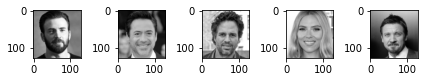

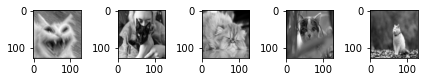

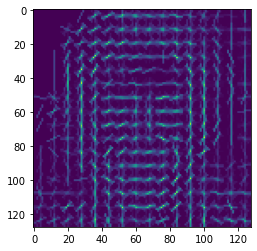

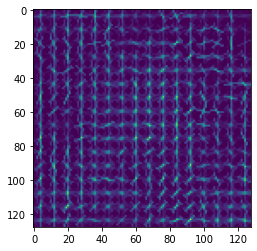

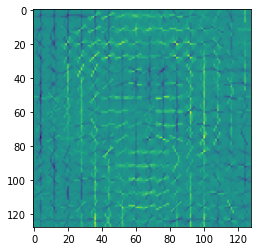

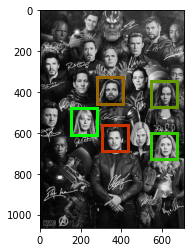

In [253]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('face_data/pos1.jpg','face_data/pos2.jpg','face_data/pos3.jpg','face_data/pos4.jpg','face_data/pos5.jpg')
negfiles = ('face_data/neg1.jpg','face_data/neg2.jpg','face_data/neg3.jpg','face_data/neg4.jpg','face_data/neg5.jpg')

# call learn_template to learn and visualize the template and training data
template =learn_template(posfiles,negfiles,tsize=tsize)
im = plt.imread('images/face_data/face_test.jpg')
if (im.dtype == np.uint8):
    im = im.astype(float) / 256
    im = np.average(im, -1)
    
# visualizing the result with the plot_detections function
detections = detect(im,template)
plot_detections(im,detections,tsize_pix)


## Experiment 2: Sushi detection

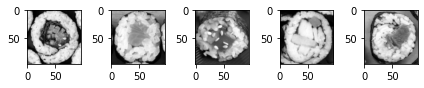

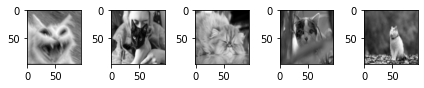

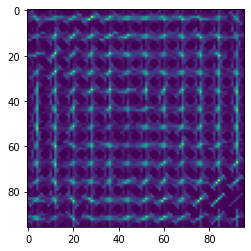

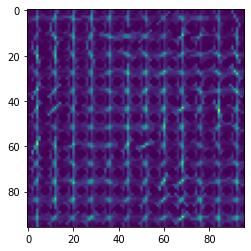

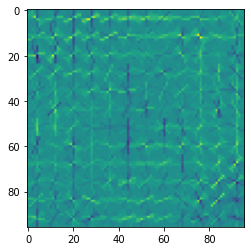

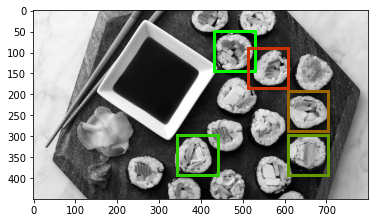

In [260]:
bsize=8
tsize=np.array([12,12])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('sushi_data/pos1.jpg','sushi_data/pos2.jpg','sushi_data/pos3.jpg','sushi_data/pos4.jpg','sushi_data/pos5.jpg')
negfiles = ('sushi_data/neg1.jpg','sushi_data/neg2.jpg','sushi_data/neg3.jpg','sushi_data/neg4.jpg','sushi_data/neg5.jpg')

# call learn_template to learn and visualize the template and training data
template =learn_template(posfiles,negfiles,tsize=tsize)
im = plt.imread('images/sushi_data/test.jpg')
if (im.dtype == np.uint8):
    im = im.astype(float) / 256
    im = np.average(im, -1)
    
# visualizing the result with the plot_detections function
detections = detect(im,template)
plot_detections(im,detections,tsize_pix)


In [ ]:
The detector implement works well when the shapes of the objects are mostly invariant. 
Major changes in the angles of objects, and images that are visually busy proved challenging
for the algoritm to navigate. Furthermore, it makes a big assumption about the size of the objects 
within the image, thus failing when the objects are presented larger or smaller than expected.
The algorithm can probably be improved by implementing a way to use color to assist detection, 
since currently only the shapes are utilized.